#Neuroevolution
#1. Evolutionary Strategies for Neural Architecture Search (ES-NAS):
Applies evolutionary strategies to automatically design neural network architectures.

In [ ]:
%pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	min     	max     
0  	20    	0.573526	0.050456	0.977803
1  	7     	0.690606	0.104854	0.977803
2  	15    	0.52079 	0.0349648	0.977803
3  	12    	0.726106	0.127129 	0.977803
4  	10    	0.702436	0.0180083	0.977803
5  	8     	0.772872	0.125841 	0.977803
6  	15    	0.572283	0.0385501	0.977803
7  	15    	0.693285	0.147365 	0.977803
8  	10    	0.65409 	0.0424557	0.997103
9  	10    	0.721806	0.144342 	0.977803
10 	13    	0.620212	0.00144039	0.977803


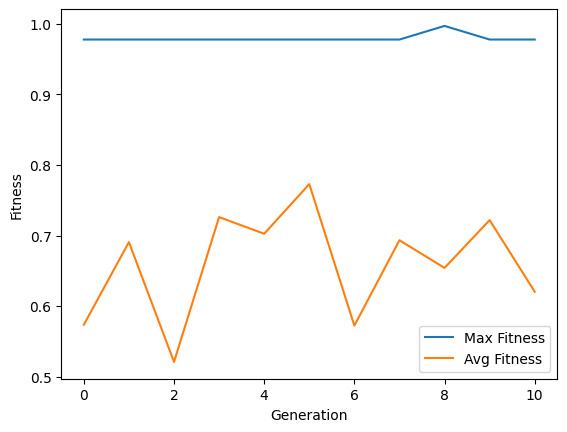

In [ ]:
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt

# Define the fitness function (evaluation metric)
def evaluate(individual):
    # Here you would train the neural network represented by the individual
    # and return its performance on the validation dataset (e.g., accuracy)
    # For demonstration purposes, we'll just return a random fitness value
    return random.random(),  # Tuple is needed as DEAP expects a tuple

# Create the toolbox
toolbox = base.Toolbox()

# Define the fitness function
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Register attributes and individuals
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=10)  # Example architecture with 10 layers
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

def main():
    # Create initial population
    population = toolbox.population(n=20)

    # Statistics to track
    stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])  # Extract the first value from the fitness tuple
    stats.register("avg", lambda x: sum(x) / len(x))
    stats.register("min", min)
    stats.register("max", max)

    # Run the evolutionary algorithm
    pop, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, stats=stats, verbose=True)

    # Extract statistics
    gen = logbook.select("gen")
    fit_max = logbook.select("max")
    fit_avg = logbook.select("avg")

    # Plotting
    plt.plot(gen, fit_max, label='Max Fitness')
    plt.plot(gen, fit_avg, label='Avg Fitness')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

#2. Neuroevolution of Augmenting Topologies (NEAT):
Evolves both the structure and weights of neural networks, enabling complex architectures to emerge.

In [ ]:
import numpy as np

# Define the activation function (sigmoid)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the Node class to represent nodes in the neural network
class Node:
    def __init__(self, node_id):
        self.node_id = node_id
        self.inputs = []
        self.output = 0
        self.bias = np.random.uniform(-1, 1)  # Initialize bias randomly

# Define the Connection class to represent connections between nodes
class Connection:
    def __init__(self, in_node, out_node, weight):
        self.in_node = in_node
        self.out_node = out_node
        self.weight = weight

# Define the Network class to represent the neural network
class Network:
    def __init__(self, input_size, output_size):
        self.nodes = []
        self.connections = []
        self.input_size = input_size
        self.output_size = output_size

        # Create input nodes
        for i in range(input_size):
            self.nodes.append(Node(i))

        # Create output nodes
        for i in range(output_size):
            self.nodes.append(Node(i + input_size))

        # Connect input nodes to output nodes
        for input_node in self.nodes[:input_size]:
            for output_node in self.nodes[input_size:]:
                self.connections.append(Connection(input_node, output_node, np.random.uniform(-1, 1)))

    # Forward propagate input through the network
    def forward(self, inputs):
        assert len(inputs) == self.input_size

        # Reset node outputs
        for node in self.nodes:
            node.output = 0

        # Set input node outputs
        for i, value in enumerate(inputs):
            self.nodes[i].output = value

        # Propagate input through the network
        for connection in self.connections:
            connection.out_node.inputs.append(connection.in_node.output * connection.weight)

        # Update node outputs
        for node in self.nodes[self.input_size:]:
            node.output = sigmoid(np.sum(node.inputs) + node.bias)
            node.inputs = []

        # Return outputs of output nodes
        return [node.output for node in self.nodes[self.input_size:]]

    # Mutate the connections of the network
    def mutate(self, mutation_rate=0.1):
        for connection in self.connections:
            if np.random.uniform() < mutation_rate:
                connection.weight += np.random.uniform(-0.5, 0.5)

# Define the fitness function
def fitness_function(network):
    # XOR problem inputs and expected outputs
    inputs = [(0, 0), (0, 1), (1, 0), (1, 1)]
    expected_outputs = [0, 1, 1, 0]
    total_error = 0

    # Evaluate the network
    for input_data, expected_output in zip(inputs, expected_outputs):
        output = network.forward(input_data)
        total_error += (output[0] - expected_output) ** 2

    # Return fitness as inverse of total error
    return 1 / (1 + total_error)

# Main NEAT algorithm
def NEAT(population_size, generations):
    # Create initial population of networks
    population = [Network(2, 1) for _ in range(population_size)]

    for generation in range(generations):
        # Evaluate fitness of each network
        fitness_scores = [fitness_function(network) for network in population]

        # Select top networks for reproduction (elitism)
        elite_indices = np.argsort(fitness_scores)[-int(population_size * 0.2):]
        elite_population = [population[i] for i in elite_indices]

        # Reproduce and mutate to create new population
        new_population = []
        for _ in range(population_size - len(elite_population)):
            parent1, parent2 = np.random.choice(elite_population, size=2, replace=False)
            child = crossover(parent1, parent2)
            child.mutate()
            new_population.append(child)

        # Combine elite and new populations
        population = elite_population + new_population

        # Print the best fitness in the current generation
        best_fitness = max(fitness_scores)
        print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")

    # Return the best network from the final generation
    best_network_index = np.argmax(fitness_scores)
    return population[best_network_index]

# Define crossover function
def crossover(parent1, parent2):
    child = Network(parent1.input_size, parent1.output_size)

    for i in range(len(child.connections)):
        if np.random.uniform() < 0.5:
            child.connections[i].weight = parent1.connections[i].weight
        else:
            child.connections[i].weight = parent2.connections[i].weight

    return child

# Define mutation function
def mutation(network, mutation_rate=0.1):
    for connection in network.connections:
        if np.random.uniform() < mutation_rate:
            connection.weight += np.random.uniform(-0.5, 0.5)

# Main function
def main():
    best_network = NEAT(population_size=50, generations=100)
    print("Best network found:")
    print(best_network.forward([0, 0]))
    print(best_network.forward([0, 1]))
    print(best_network.forward([1, 0]))
    print(best_network.forward([1, 1]))

if __name__ == "__main__":
    main()

Generation 1: Best Fitness = 0.49645515889408803
Generation 2: Best Fitness = 0.49690633849548327
Generation 3: Best Fitness = 0.49791116530685003
Generation 4: Best Fitness = 0.49791116530685003
Generation 5: Best Fitness = 0.49879422440647103
Generation 6: Best Fitness = 0.49879422440647103
Generation 7: Best Fitness = 0.4997901757756344
Generation 8: Best Fitness = 0.4997901757756344
Generation 9: Best Fitness = 0.4997901757756344
Generation 10: Best Fitness = 0.4997901757756344
Generation 11: Best Fitness = 0.4997901757756344
Generation 12: Best Fitness = 0.4997921981560926
Generation 13: Best Fitness = 0.4997921981560926
Generation 14: Best Fitness = 0.4997921981560926
Generation 15: Best Fitness = 0.4997921981560926
Generation 16: Best Fitness = 0.4997921981560926
Generation 17: Best Fitness = 0.4997921981560926
Generation 18: Best Fitness = 0.4997945271126447
Generation 19: Best Fitness = 0.4997945271126447
Generation 20: Best Fitness = 0.4997945271126447
Generation 21: Best Fit

Generation 1: Best Fitness = 0.49829990657912515
Generation 2: Best Fitness = 0.49859479722315775
Generation 3: Best Fitness = 0.49859479722315775
Generation 4: Best Fitness = 0.4989309222428252
Generation 5: Best Fitness = 0.4989309222428252
Generation 6: Best Fitness = 0.4989527061320351
Generation 7: Best Fitness = 0.4994507882851743
Generation 8: Best Fitness = 0.49953612111137935
Generation 9: Best Fitness = 0.4996135305046027
Generation 10: Best Fitness = 0.4996135305046027
Generation 11: Best Fitness = 0.4996135305046027
Generation 12: Best Fitness = 0.499727673466886
Generation 13: Best Fitness = 0.499727673466886
Generation 14: Best Fitness = 0.49973699389283616
Generation 15: Best Fitness = 0.4998811530764591
Generation 16: Best Fitness = 0.4998811530764591
Generation 17: Best Fitness = 0.4998811530764591
Generation 18: Best Fitness = 0.4998811530764591
Generation 19: Best Fitness = 0.4998811530764591
Generation 20: Best Fitness = 0.4998811530764591
Generation 21: Best Fitnes

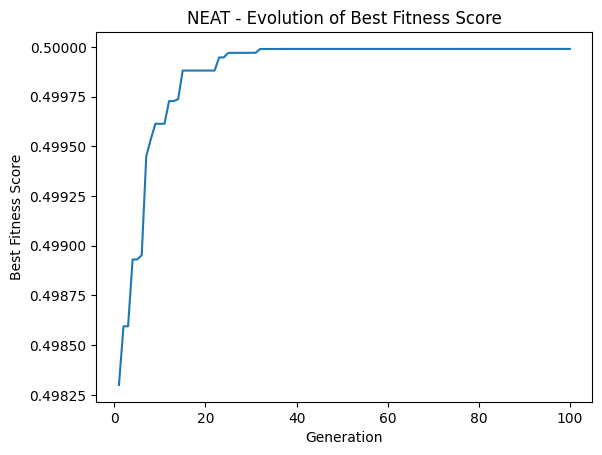

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the activation function (sigmoid)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the Node class to represent nodes in the neural network
class Node:
    def __init__(self, node_id):
        self.node_id = node_id
        self.inputs = []
        self.output = 0
        self.bias = np.random.uniform(-1, 1)  # Initialize bias randomly

# Define the Connection class to represent connections between nodes
class Connection:
    def __init__(self, in_node, out_node, weight):
        self.in_node = in_node
        self.out_node = out_node
        self.weight = weight

# Define the Network class to represent the neural network
class Network:
    def __init__(self, input_size, output_size):
        self.nodes = []
        self.connections = []
        self.input_size = input_size
        self.output_size = output_size

        # Create input nodes
        for i in range(input_size):
            self.nodes.append(Node(i))

        # Create output nodes
        for i in range(output_size):
            self.nodes.append(Node(i + input_size))

        # Connect input nodes to output nodes
        for input_node in self.nodes[:input_size]:
            for output_node in self.nodes[input_size:]:
                self.connections.append(Connection(input_node, output_node, np.random.uniform(-1, 1)))

    # Forward propagate input through the network
    def forward(self, inputs):
        assert len(inputs) == self.input_size

        # Reset node outputs
        for node in self.nodes:
            node.output = 0

        # Set input node outputs
        for i, value in enumerate(inputs):
            self.nodes[i].output = value

        # Propagate input through the network
        for connection in self.connections:
            connection.out_node.inputs.append(connection.in_node.output * connection.weight)

        # Update node outputs
        for node in self.nodes[self.input_size:]:
            node.output = sigmoid(np.sum(node.inputs) + node.bias)
            node.inputs = []

        # Return outputs of output nodes
        return [node.output for node in self.nodes[self.input_size:]]

    # Mutate the connections of the network
    def mutate(self, mutation_rate=0.1):
        for connection in self.connections:
            if np.random.uniform() < mutation_rate:
                connection.weight += np.random.uniform(-0.5, 0.5)

# Define the fitness function
def fitness_function(network):
    # XOR problem inputs and expected outputs
    inputs = [(0, 0), (0, 1), (1, 0), (1, 1)]
    expected_outputs = [0, 1, 1, 0]
    total_error = 0

    # Evaluate the network
    for input_data, expected_output in zip(inputs, expected_outputs):
        output = network.forward(input_data)
        total_error += (output[0] - expected_output) ** 2

    # Return fitness as inverse of total error
    return 1 / (1 + total_error)

# Main NEAT algorithm
def NEAT(population_size, generations):
    best_fitness_scores = []  # Store best fitness score for each generation

    # Create initial population of networks
    population = [Network(2, 1) for _ in range(population_size)]

    for generation in range(generations):
        # Evaluate fitness of each network
        fitness_scores = [fitness_function(network) for network in population]

        # Store best fitness score for current generation
        best_fitness_scores.append(max(fitness_scores))

        # Select top networks for reproduction (elitism)
        elite_indices = np.argsort(fitness_scores)[-int(population_size * 0.2):]
        elite_population = [population[i] for i in elite_indices]

        # Reproduce and mutate to create new population
        new_population = []
        for _ in range(population_size - len(elite_population)):
            parent1, parent2 = np.random.choice(elite_population, size=2, replace=False)
            child = crossover(parent1, parent2)
            child.mutate()
            new_population.append(child)

        # Combine elite and new populations
        population = elite_population + new_population

        # Print the best fitness in the current generation
        best_fitness = max(fitness_scores)
        print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")

    # Return the best fitness scores for each generation
    return best_fitness_scores

# Define crossover function
def crossover(parent1, parent2):
    child = Network(parent1.input_size, parent1.output_size)

    for i in range(len(child.connections)):
        if np.random.uniform() < 0.5:
            child.connections[i].weight = parent1.connections[i].weight
        else:
            child.connections[i].weight = parent2.connections[i].weight

    return child

# Main function
def main():
    generations = 100
    population_size = 50
    best_fitness_scores = NEAT(population_size, generations)

    # Plotting the results
    plt.plot(range(1, generations + 1), best_fitness_scores)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Score')
    plt.title('NEAT - Evolution of Best Fitness Score')
    plt.show()

if __name__ == "__main__":
    main()

#3. Population-based Training (PBT):
Utilizes evolutionary principles to dynamically adjust hyperparameters during neural network training.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define the neural network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the PBT algorithm
def PBT(population_size, generations, alpha=0.2, beta=0.2):
    # Initialize population of hyperparameters
    populations = [{'lr': np.random.uniform(0.001, 0.01), 'batch_size': np.random.choice([32, 64, 128]),
                    'loss': np.inf}
                   for _ in range(population_size)]  # Initialize loss with infinity

    for generation in range(generations):
        print(f"Generation {generation + 1}")

        # Train models with different hyperparameters
        for hyperparams in populations:
            # Set hyperparameters for training
            lr = hyperparams['lr']
            batch_size = hyperparams['batch_size']
            model.optimizer.learning_rate.assign(lr)

            # Train the model
            model.fit(x_train, y_train, epochs=1, batch_size=batch_size, verbose=0)

            # Evaluate the model
            loss, _ = model.evaluate(x_test, y_test, verbose=0)

            # Update hyperparameters based on performance
            for other_params in populations:
                if other_params != hyperparams:
                    if np.random.uniform() < alpha and loss < other_params['loss']:  # If current loss is better
                        for key in hyperparams:
                            if np.random.uniform() < beta:
                                hyperparams[key] = other_params[key]
                                hyperparams['loss'] = loss  # Update the loss

        print("Hyperparameters after generation:")
        print(populations)

    # Return the best set of hyperparameters
    best_hyperparams = min(populations, key=lambda x: x['loss'])  # Choose the hyperparameters with the lowest loss
    return best_hyperparams

# Main function
def main():
    best_hyperparams = PBT(population_size=5, generations=3)
    print("Best hyperparameters found:")
    print(best_hyperparams)

if __name__ == "__main__":
    main()

Generation 1
Hyperparameters after generation:
[{'lr': 0.008367172649608588, 'batch_size': 64, 'loss': inf}, {'lr': 0.008615957900042825, 'batch_size': 128, 'loss': inf}, {'lr': 0.0015832120225851552, 'batch_size': 64, 'loss': 0.14813971519470215}, {'lr': 0.008615957900042825, 'batch_size': 128, 'loss': 0.0951395109295845}, {'lr': 0.0015832120225851552, 'batch_size': 32, 'loss': 0.10026301443576813}]
Generation 2
Hyperparameters after generation:
[{'lr': 0.008367172649608588, 'batch_size': 64, 'loss': inf}, {'lr': 0.008615957900042825, 'batch_size': 128, 'loss': inf}, {'lr': 0.0015832120225851552, 'batch_size': 64, 'loss': 0.08612814545631409}, {'lr': 0.008615957900042825, 'batch_size': 128, 'loss': 0.0951395109295845}, {'lr': 0.0015832120225851552, 'batch_size': 32, 'loss': 0.10026301443576813}]
Generation 3
Hyperparameters after generation:
[{'lr': 0.008367172649608588, 'batch_size': 64, 'loss': inf}, {'lr': 0.008615957900042825, 'batch_size': 128, 'loss': inf}, {'lr': 0.001583212022

#4. Cooperative Coevolutionary Neuroevolution:
 Evolves modular components of neural networks independently, facilitating scalable optimization of large networks.

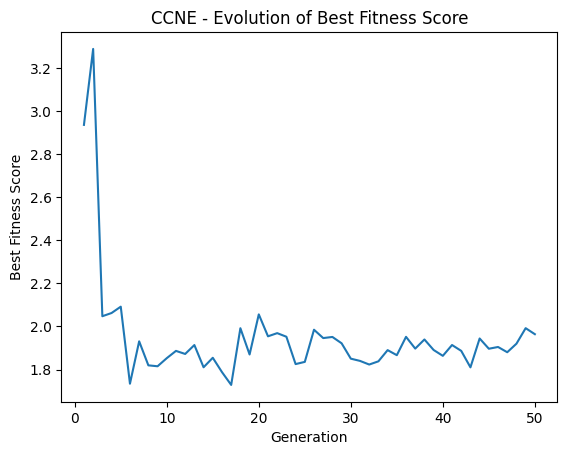

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the fitness function
def fitness_function(weights):
    # This is a placeholder fitness function
    # In a real scenario, this function would evaluate the performance of the modular neural network
    return np.sum(weights)

# Define the Cooperative Coevolutionary Neuroevolution algorithm
def CCNE(population_size, generations, num_modules, module_size):
    best_fitness_scores = []  # Store best fitness score for each generation

    # Initialize populations for each module
    populations = [np.random.uniform(-1, 1, size=module_size) for _ in range(num_modules)]

    for generation in range(generations):
        # Evaluate fitness of each population
        fitness_scores = [fitness_function(population) for population in populations]

        # Store best fitness score for current generation
        best_fitness_scores.append(max(fitness_scores))

        # Perform crossover between populations
        for i in range(num_modules):
            for j in range(i + 1, num_modules):
                # Perform crossover by taking the average of corresponding weights
                crossover_point = np.random.randint(0, module_size)
                populations[i][:crossover_point] = (populations[i][:crossover_point] + populations[j][:crossover_point]) / 2
                populations[j][:crossover_point] = populations[i][:crossover_point]

        # Perform mutation on populations
        for population in populations:
            mutation_rate = 0.1
            mutation_mask = np.random.rand(*population.shape) < mutation_rate
            population += mutation_mask * np.random.uniform(-0.1, 0.1, size=population.shape)

    # Return the best fitness scores for each generation
    return best_fitness_scores

# Main function
def main():
    generations = 50
    num_modules = 5
    module_size = 10
    population_size = 10
    best_fitness_scores = CCNE(population_size, generations, num_modules, module_size)

    # Plotting the results
    plt.plot(range(1, generations + 1), best_fitness_scores)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Score')
    plt.title('CCNE - Evolution of Best Fitness Score')
    plt.show()

if __name__ == "__main__":
    main()

#5. Differential Neural Architecture Search (DNAS):
Combines differential evolution with neural architecture search techniques to efficiently explore the space of neural network designs.

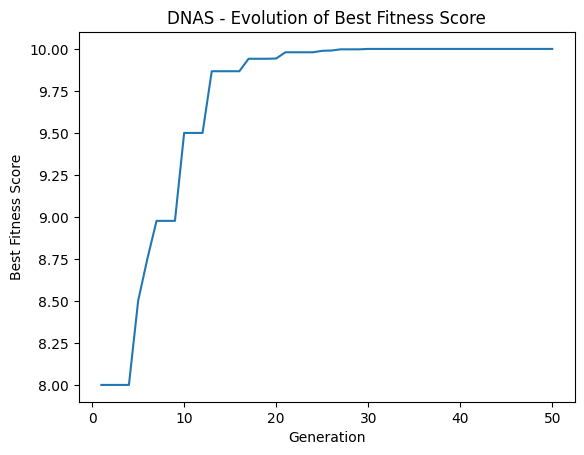

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the fitness function
def fitness_function(architecture):
    # This is a placeholder fitness function
    # In a real scenario, this function would evaluate the performance of the neural network with the given architecture
    return np.sum(architecture)

# Define the Differential Neural Architecture Search algorithm
def DNAS(population_size, generations, num_arch_params, differential_weight=0.5, crossover_prob=0.7):
    best_fitness_scores = []  # Store best fitness score for each generation

    # Initialize population of neural network architectures
    population = [np.random.randint(2, size=num_arch_params) for _ in range(population_size)]

    for generation in range(generations):
        # Evaluate fitness of each architecture
        fitness_scores = [fitness_function(architecture) for architecture in population]

        # Store best fitness score for current generation
        best_fitness_scores.append(max(fitness_scores))

        # Perform differential evolution
        for i in range(population_size):
            # Select three distinct individuals from the population
            indices = np.random.choice(range(population_size), size=3, replace=False)
            a, b, c = [population[index] for index in indices]

            # Perform mutation using differential evolution
            mutated_architecture = np.clip(a + differential_weight * (b - c), 0, 1)

            # Perform crossover with the original architecture
            if np.random.uniform() < crossover_prob:
                mask = np.random.randint(2, size=num_arch_params)
                mutated_architecture = np.where(mask, mutated_architecture, population[i])

            # Replace the original architecture with the mutated one if it has higher fitness
            if fitness_function(mutated_architecture) > fitness_scores[i]:
                population[i] = mutated_architecture

    # Return the best fitness scores for each generation
    return best_fitness_scores

# Main function
def main():
    generations = 50
    population_size = 10
    num_arch_params = 10
    best_fitness_scores = DNAS(population_size, generations, num_arch_params)

    # Plotting the results
    plt.plot(range(1, generations + 1), best_fitness_scores)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Score')
    plt.title('DNAS - Evolution of Best Fitness Score')
    plt.show()

if __name__ == "__main__":
    main()
